# LCPB 20-21 exercise 1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

2. Show a quantitative statistical comparison of the performance of different algorithms:
* Vanilla gradient descent
* Gradient descent with momentum
* Nesterov (NAG)
* RMSprop
* ADAM

for this function on the right or for the
function in the next page.
Define a grid Q of initial points equally
spaced in the square S=[-3,3]x[-3,3].
Perform a minimization starting from
each of the points in Q, and compute the
average value of the function vs time
during these minimizations, for each
method (with a good value of its own
learning rate, chosen after some test).

In [20]:
## Parameters
w, b, q = 10, 20, 1/10

## Target function
f = lambda x,y: b*(1-np.exp(-1/2*w*(x**2 + y**2))) + 1/2*q*(y - x**3)**2

## Gradient of the function
def d_f_x(params):
    x, y = params
    return b*w*np.exp(-1/2*w*(x**2 + y**2))*x - 3*q*(y - x**3)*x**2
def d_f_y(params):
    x, y = params
    return b*w*np.exp(-1/2*w*(x**2 + y**2))*y + q*(y-x**3)

g_f = lambda params: np.array([d_f_x(params),d_f_y(params)])



In [8]:
## Gradient methods. Adapted from mlreview_notebooks.

#Mean-gradient based methods
def gd(grad, init, n_epochs=1000, eta=10**-2, noise_strength=0):
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj


def gd_with_mom(grad, init, n_epochs=5000, eta=10**-2, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

def NAG(grad, init, n_epochs=5000, eta=10**-2, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

#Methods that exploit first and second moments of gradient: RMS-PROP and ADAMS

def rms_prop(grad, init, n_epochs=5000, eta=10**-2, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj
                        
                        
def adams(grad, init, n_epochs=5000, eta=10**-2, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj


In [22]:
## Building initial positions grid:
# Couldn't make this work the way I intended
# xv, yv = np.meshgrid(np.linspace(-3,3),np.linspace(-3,3),sparse=True)
## I don't love this approach, too programming 101
init_points = []
x = np.linspace(-3,3)
y = np.linspace(-3,3)
for i in x:
    for j in y:
        init_points.append([i,j])
# init_points is now the [-3,3]x[-3,3] grid

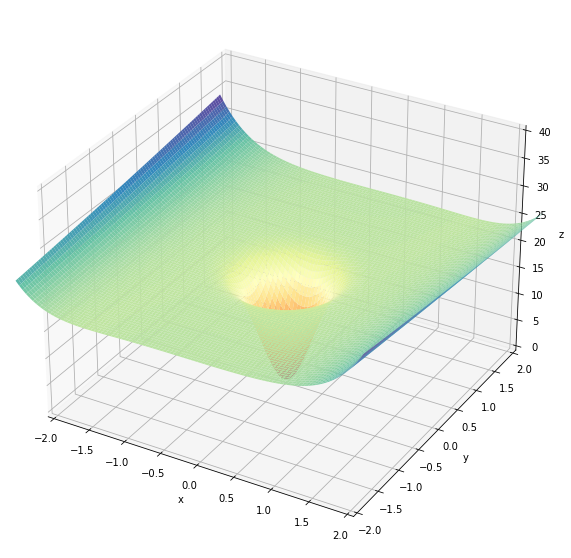

In [23]:
# Create the domain points
x = np.linspace(-2.3, 2.3, 100)
y = np.linspace(-2.3, 2.3, 100)

X, Y = np.meshgrid(x, y)

# Generate the value according to the function
Z = f(X, Y)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral')
ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(0, 40)
#ax.set_title(''); # For the title
#ax.view_init(45, -65) # To change the view orientation
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


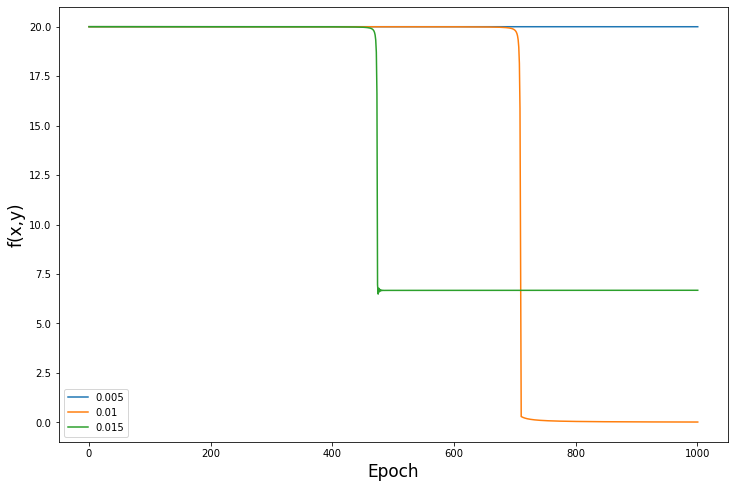

In [24]:
eta = [0.5e-2,1.e-2,1.5e-2]

for i in eta:
    coordinates = gd(g_f, [1.,1.], n_epochs=1000, eta=i, noise_strength=0)
    z_p = f(coordinates[:,0],coordinates[:,1])
    plt.plot(np.linspace(0, len(z_p), num=len(z_p)),z_p,label=i)
plt.rcParams["figure.figsize"] = (12,8)
plt.ylabel('f(x,y)',fontsize=17)  
plt.xlabel('Epoch',fontsize=17)
plt.legend()
plt.show()

In [25]:
## 
def get_step_avg(method,f,grad_f,init_points, n_epochs = 1000):
    results = []
    for init_pair in init_points:
        # too reliant on the brute force grid
        results.append(method(grad_f,init_pair,n_epochs=n_epochs))
    tray = np.array(results)
    step_avg = np.average(f(tray[:,:,0],tray[:,:,1]), axis = 0)
    return step_avg

In [26]:
h1 = get_step_avg(gd,f,g_f,init_points, n_epochs = 100)
h2 = get_step_avg(gd_with_mom,f,g_f,init_points, n_epochs = 100)
h3 = get_step_avg(NAG,f,g_f,init_points, n_epochs = 100)
h4 = get_step_avg(rms_prop,f,g_f,init_points, n_epochs = 100)
h5 = get_step_avg(adams,f,g_f,init_points, n_epochs = 100)

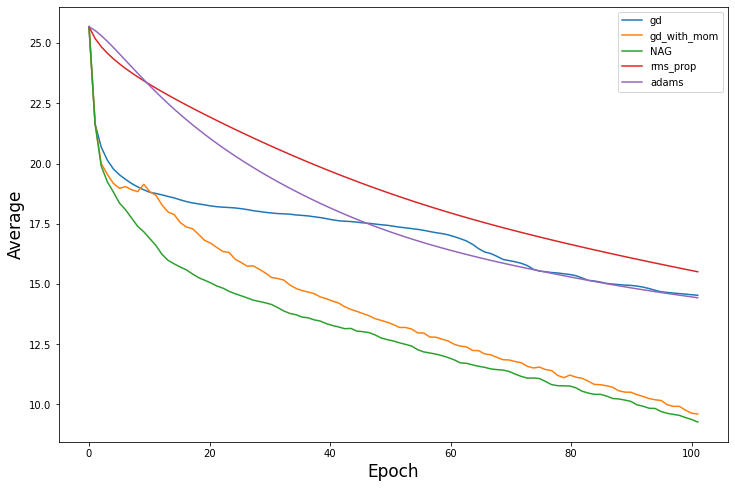

In [27]:
t = np.linspace(0,len(h1),num=len(h1))

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(t,h1,label='gd')
plt.plot(t,h2,label='gd_with_mom')
plt.plot(t,h3,label='NAG')
plt.plot(t,h4,label='rms_prop')
plt.plot(t,h5,label='adams')
plt.ylabel('Average',fontsize=17)  
plt.xlabel('Epoch',fontsize=17)
plt.legend()
plt.show()

3. OPTIONAL: 
For a simple function, show an example where ADAM algorithm starts to
become unstable with respect to a minimum that was reached at some earlier iteration t.

In [80]:
f3 = lambda x,y: 1 + 1*(x**2 + y**2) - np.cos(2*np.pi*(x*y-y**2))

## Gradient of the function
def d_f3_x(params):
    x, y = params
    return 2*x + 2*np.pi*y*np.sin(2*np.pi*(x*y-y**2))
def d_f3_y(params):
    x, y = params
    return 2*y + 2*np.pi*(x-2*y)*np.sin(2*np.pi*(x*y-y**2))

g_f3 = lambda params: np.array([d_f3_x(params),d_f3_y(params)])

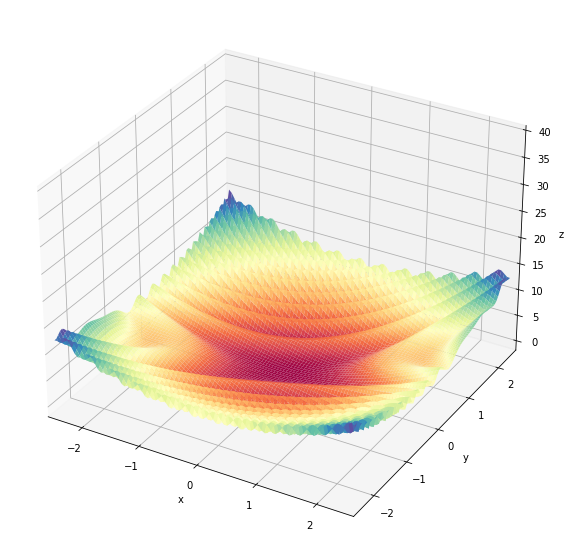

In [81]:
# Create the domain points
x = np.linspace(-2.5, 2.5, 100)
y = np.linspace(-2.5, 2.5, 100)

X, Y = np.meshgrid(x, y)

# Generate the value according to the function
Z = f3(X, Y)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral')
ax.set_xlim3d(-2.5, 2.5)
ax.set_ylim3d(-2.5, 2.5)
ax.set_zlim3d(-1, 40)
#ax.set_title(''); # For the title
#ax.view_init(45, -65) # To change the view orientation
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

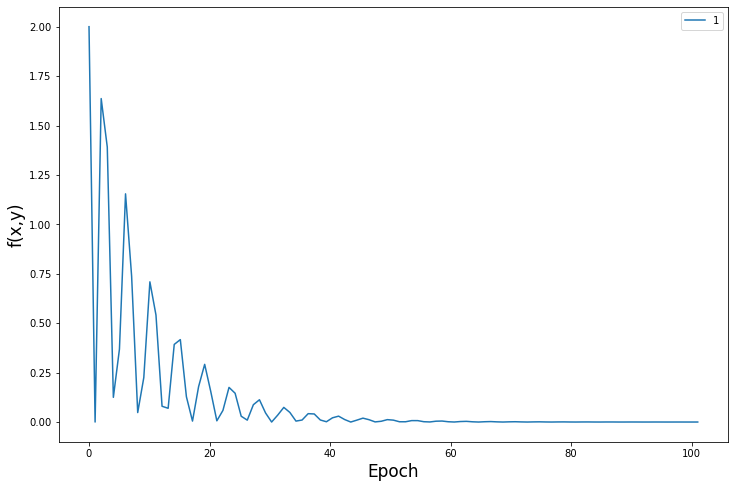

In [105]:
eta3 = 1 # try to change it 

# try to change epochs and noise_strenght
coordinates3 = adams(g_f3, [1.,1.], n_epochs=100, eta=eta3, noise_strength=0)
z_p3 = f3(coordinates3[:,0],coordinates3[:,1])
plt.plot(np.linspace(0, len(z_p3), num=len(z_p3)),z_p3,label=eta3)
plt.rcParams["figure.figsize"] = (12,8)
plt.ylabel('f(x,y)',fontsize=17)  
plt.xlabel('Epoch',fontsize=17)
plt.legend()
plt.show()